In [1]:
import pandas as pd
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
warnings.filterwarnings("ignore")


data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)

stocks = pd.DataFrame(data[0])


C:\Users\jackm\AppData\Local\Temp\ipykernel_10040\3139877759.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
stocks.Symbol = stocks.Symbol.str.replace(".", "-")
stocks.set_index('Symbol', inplace=True, drop=True)
stock_prices = yf.download(list(stocks.index), '2022-1-1', auto_adjust=True, group_by='Symbol')


[*********************100%***********************]  503 of 503 completed


In [3]:
stock_prices.columns.levels

stock_prices = stock_prices.drop(['Open', 'High', 'Low', 'Volume'], level=1, axis=1)
stock_prices.tail()

,VTR,DG,TER,ABBV,DOW,DFS,DPZ,ETR,LLY,BBWI,...,RCL,PNR,HLT,EQT,TEL,VZ,ITW,AEP,LDOS,RTX
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-05,44.660000,158.869995,101.519997,136.860001,51.500000,109.040001,297.829987,99.760002,444.260010,39.799999,...,87.599998,58.000000,142.570007,36.040001,124.199997,34.459999,225.600006,84.000000,80.660004,95.750000
2023-06-06,45.330002,157.110001,103.070000,135.429993,52.590000,112.330002,297.739990,98.970001,443.070007,40.380001,...,90.720001,59.049999,144.600006,37.360001,127.260002,34.700001,228.979996,83.440002,81.330002,97.440002
2023-06-07,46.389999,155.539993,104.220001,136.500000,53.869999,113.099998,297.559998,101.309998,436.369995,41.189999,...,91.010002,60.799999,142.630005,38.810001,128.500000,35.259998,236.440002,84.580002,82.699997,98.589996
2023-06-08,44.740002,155.850006,104.669998,137.639999,52.779999,113.589996,299.899994,101.500000,445.660004,42.000000,...,90.239998,59.889999,142.880005,38.970001,128.000000,35.430000,237.009995,84.680000,82.550003,99.080002
2023-06-09,45.720001,153.050003,105.019997,138.179993,51.740002,114.139999,298.070007,101.440002,446.040009,42.230000,...,91.220001,59.169998,141.529999,38.549999,128.000000,35.470001,237.509995,83.680000,82.910004,99.339996


In [4]:
# Calculate top volatility decile

stock_prices.index = pd.to_datetime(stock_prices.index)

In [5]:
price_pct_change = stock_prices.pct_change()
price_pct_change.columns

MultiIndex([( 'VTR', 'Close'),
            (  'DG', 'Close'),
            ( 'TER', 'Close'),
            ('ABBV', 'Close'),
            ( 'DOW', 'Close'),
            ( 'DFS', 'Close'),
            ( 'DPZ', 'Close'),
            ( 'ETR', 'Close'),
            ( 'LLY', 'Close'),
            ('BBWI', 'Close'),
            ...
            ( 'RCL', 'Close'),
            ( 'PNR', 'Close'),
            ( 'HLT', 'Close'),
            ( 'EQT', 'Close'),
            ( 'TEL', 'Close'),
            (  'VZ', 'Close'),
            ( 'ITW', 'Close'),
            ( 'AEP', 'Close'),
            ('LDOS', 'Close'),
            ( 'RTX', 'Close')],
           length=503)

In [6]:
# calculate standard deviation
stock_std = price_pct_change.std()
stock_std.axes

[MultiIndex([( 'VTR', 'Close'),
             (  'DG', 'Close'),
             ( 'TER', 'Close'),
             ('ABBV', 'Close'),
             ( 'DOW', 'Close'),
             ( 'DFS', 'Close'),
             ( 'DPZ', 'Close'),
             ( 'ETR', 'Close'),
             ( 'LLY', 'Close'),
             ('BBWI', 'Close'),
             ...
             ( 'RCL', 'Close'),
             ( 'PNR', 'Close'),
             ( 'HLT', 'Close'),
             ( 'EQT', 'Close'),
             ( 'TEL', 'Close'),
             (  'VZ', 'Close'),
             ( 'ITW', 'Close'),
             ( 'AEP', 'Close'),
             ('LDOS', 'Close'),
             ( 'RTX', 'Close')],
            length=503)]

50


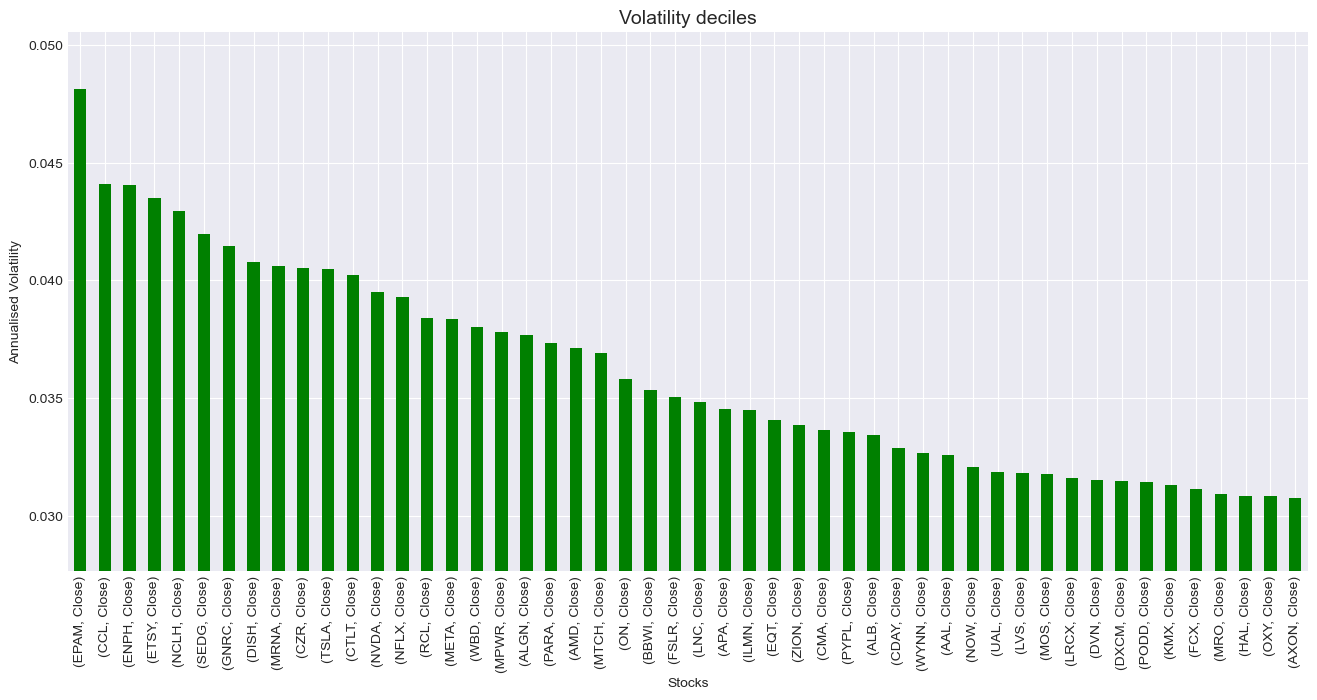

In [7]:
volatility_sort = stock_std.sort_values(ascending=False)
volatility_sort
topdecile = volatility_sort[:int(len(stock_std)*0.1)]
print(topdecile.count())
topdecile.plot.bar(figsize=(16,7),color='green',ylim=topdecile.min()*0.9)
plt.title('Volatility deciles', fontsize=14)
plt.xlabel('Stocks')
plt.ylabel('Annualised Volatility')
plt.show()

In [8]:
stock_prices_pc = stock_prices.loc['2022-1':,topdecile.index]

stock_prices_pc = stock_prices.pct_change()


In [9]:
topdecile.index

MultiIndex([('EPAM', 'Close'),
            ( 'CCL', 'Close'),
            ('ENPH', 'Close'),
            ('ETSY', 'Close'),
            ('NCLH', 'Close'),
            ('SEDG', 'Close'),
            ('GNRC', 'Close'),
            ('DISH', 'Close'),
            ('MRNA', 'Close'),
            ( 'CZR', 'Close'),
            ('TSLA', 'Close'),
            ('CTLT', 'Close'),
            ('NVDA', 'Close'),
            ('NFLX', 'Close'),
            ( 'RCL', 'Close'),
            ('META', 'Close'),
            ( 'WBD', 'Close'),
            ('MPWR', 'Close'),
            ('ALGN', 'Close'),
            ('PARA', 'Close'),
            ( 'AMD', 'Close'),
            ('MTCH', 'Close'),
            (  'ON', 'Close'),
            ('BBWI', 'Close'),
            ('FSLR', 'Close'),
            ( 'LNC', 'Close'),
            ( 'APA', 'Close'),
            ('ILMN', 'Close'),
            ( 'EQT', 'Close'),
            ('ZION', 'Close'),
            ( 'CMA', 'Close'),
            ('PYPL', 'Close'),
        

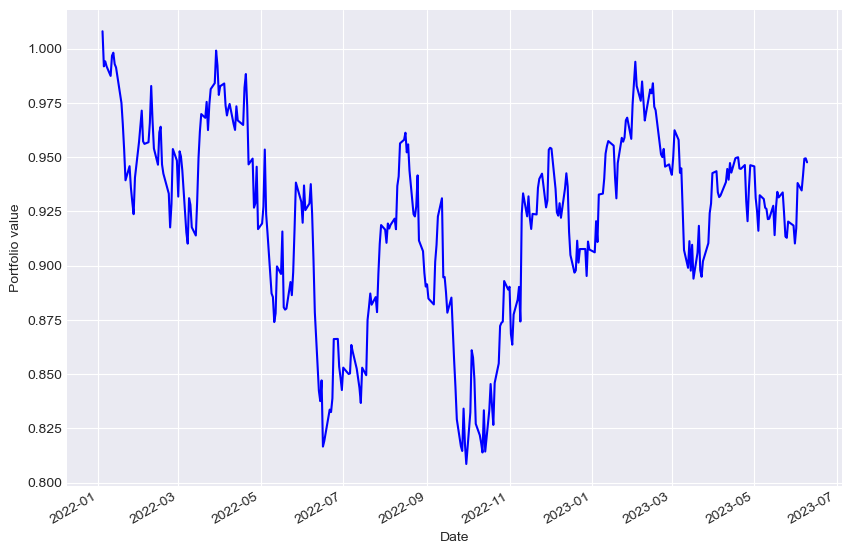

In [10]:

portfolio = pd.DataFrame()
portfolio['returns'] = stock_prices_pc.mean(axis=1)
portfolio['value'] = (portfolio+1).cumprod()
portfolio = portfolio.dropna()
portfolio.value.plot(color='b',figsize=(10,7))
plt.ylabel("Portfolio value")
plt.show()

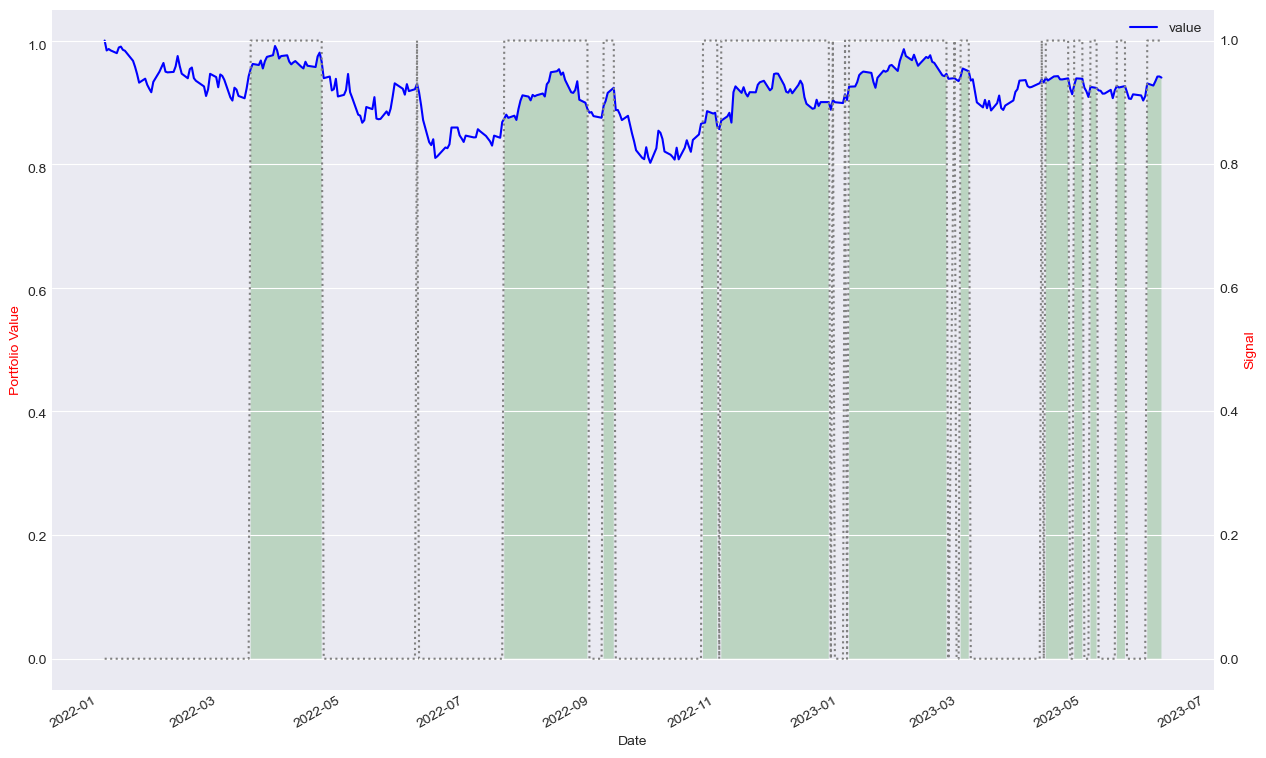

In [11]:
import numpy as np
def get_strategy_returns_sma(portfolio):
    # Calculate the simple moving average of period 10
    portfolio['sma10'] = portfolio.value.rolling(window=50).mean()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value > portfolio.sma10,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()

portfolio = get_strategy_returns_sma(portfolio)    
plot_signal(portfolio)  

The Sharpe ratio is -0.31 


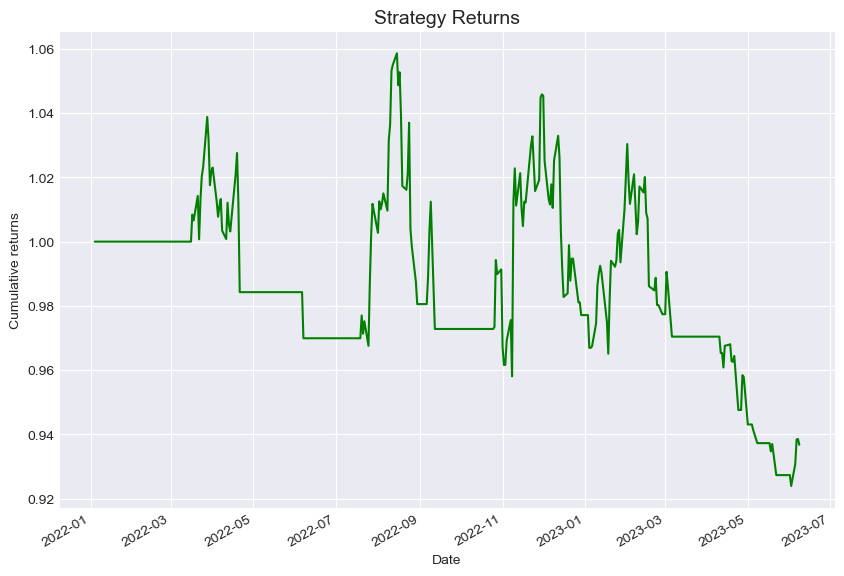

The maximum drawdown is -12.72


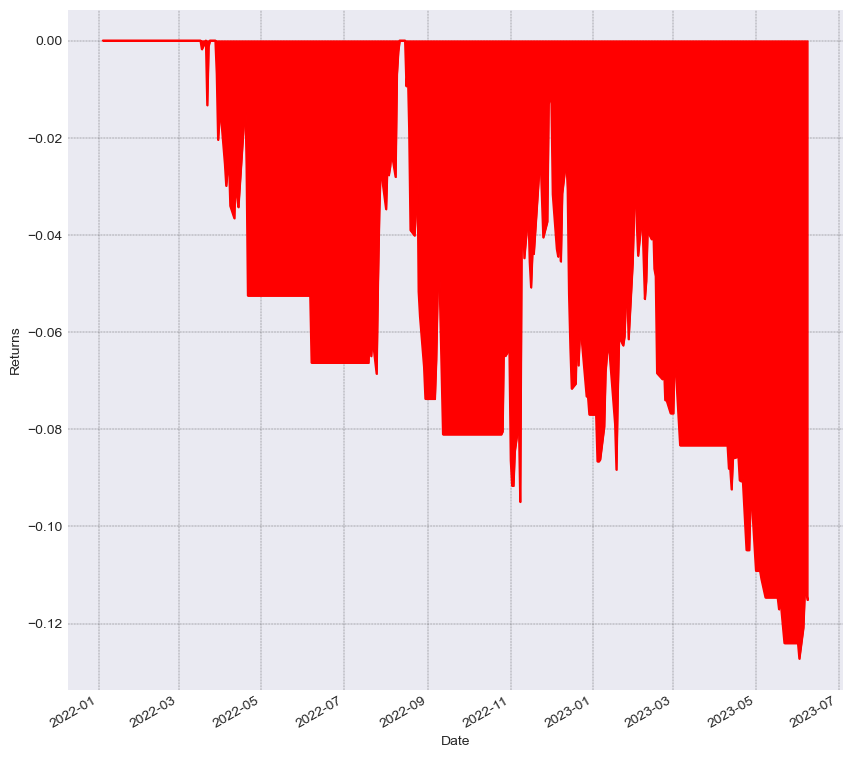

In [12]:
def plot_returns_dd(portfolio):
    # ----------- Sharpe ratio ------------------
    sharpe_ratio = np.mean(portfolio.str_returns)/np.std(portfolio.str_returns)*(252**0.5)
    print('The Sharpe ratio is %.2f ' % sharpe_ratio)

    # ----------- Cumulative strategy returns ------------------
    portfolio['cum_str_returns'] = (portfolio['str_returns']+1).cumprod()
    # Plot the cumulative strategy returns
    portfolio['cum_str_returns'].plot(figsize=(10,7), color='green')
    plt.title('Strategy Returns', fontsize=14)
    plt.ylabel('Cumulative returns')
    plt.show()        

    # ----------- Drawdown ------------------    
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio['cum_str_returns'].dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (portfolio['cum_str_returns'])/running_max - 1
    max_dd = drawdown.min()*100
    print('The maximum drawdown is %.2f' % max_dd)
    # Plot the drawdowns
    drawdown.plot(color='r',figsize=(10,10))
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()    
    
plot_returns_dd(portfolio)   

The Sharpe ratio is -0.77 


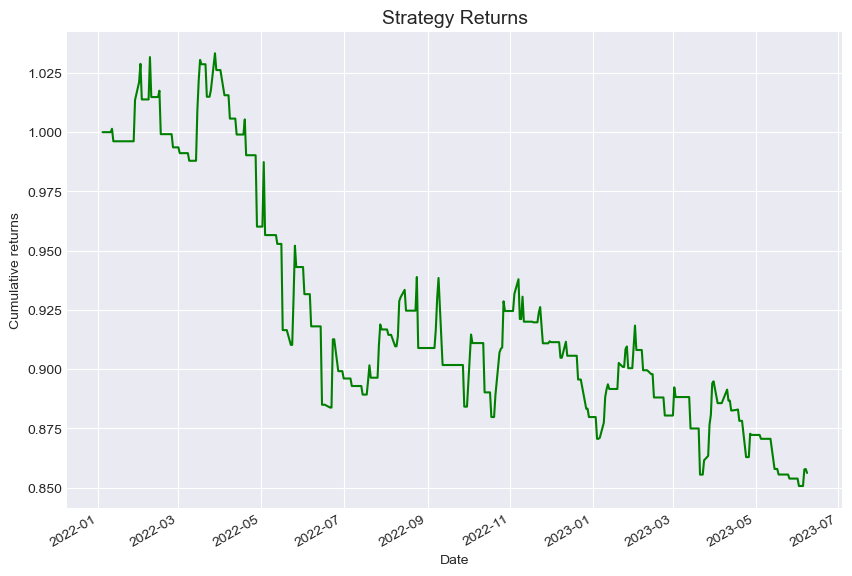

The maximum drawdown is -17.67


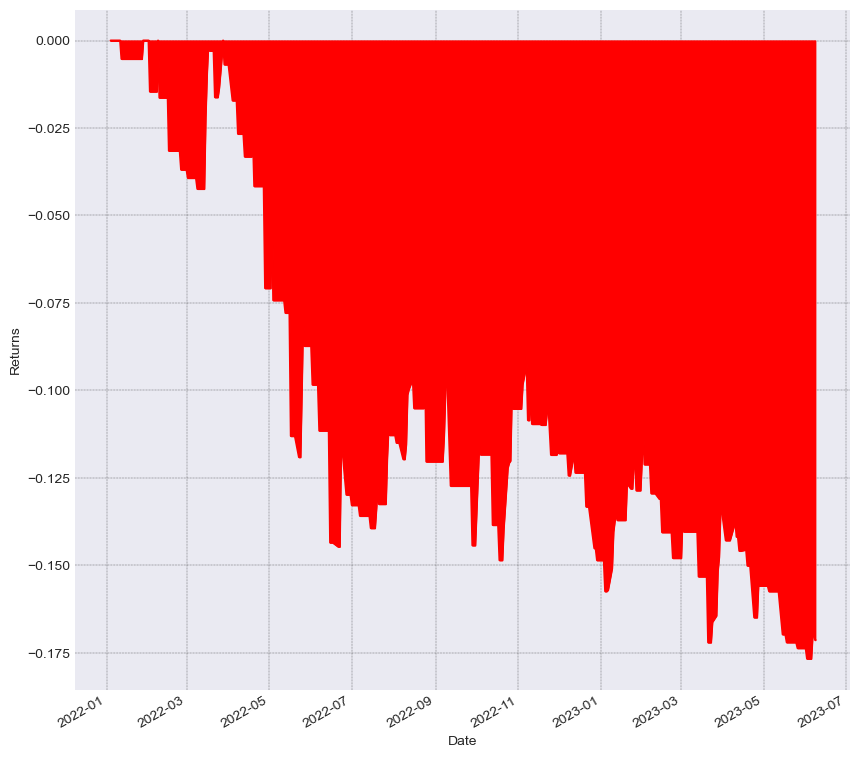

In [13]:
def get_strategy_returns_breakout(portfolio):
    # Calculate the breakout indicator values
    portfolio['high'] = portfolio.value.rolling(window=3).max()
    # Create a trading signal
    portfolio['signal'] = np.where(portfolio.value>=portfolio.high,1,0)
    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio

portfolio = get_strategy_returns_breakout(portfolio)
# plot_signal(portfolio)    
plot_returns_dd(portfolio)

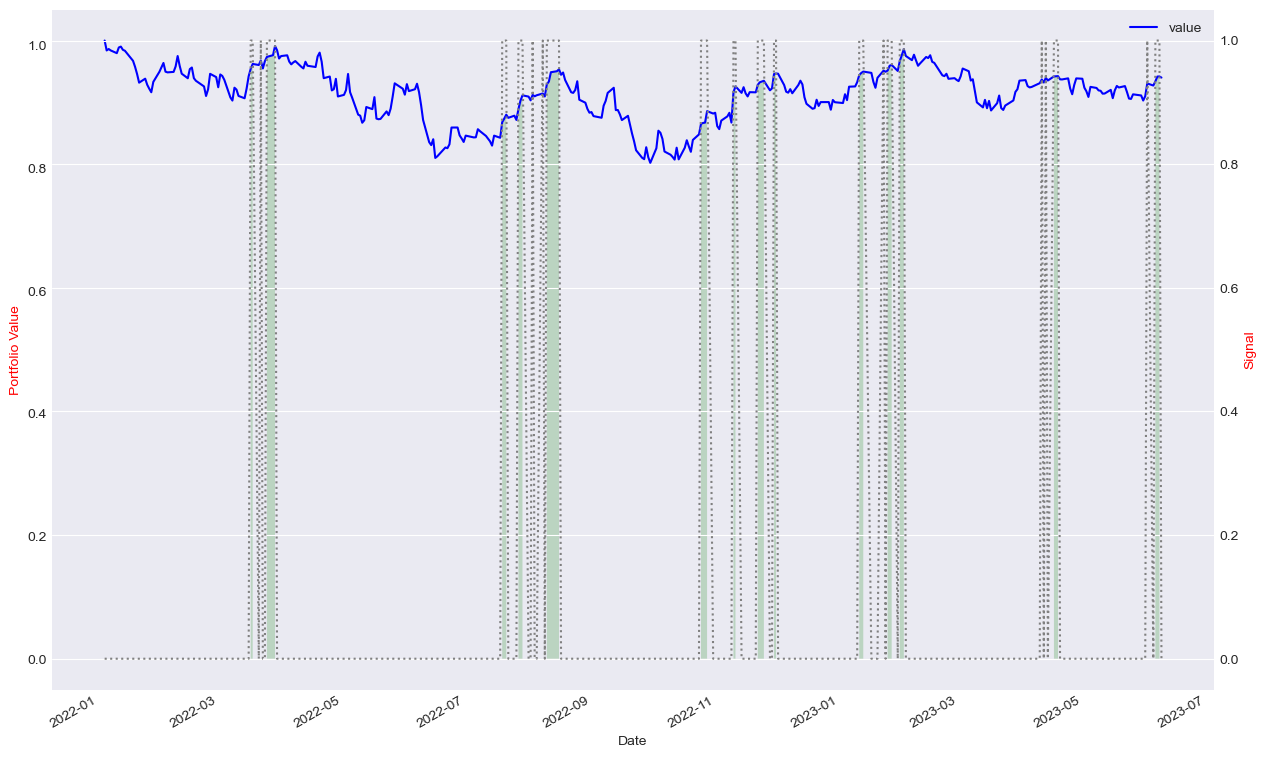

The Sharpe ratio is 0.77 


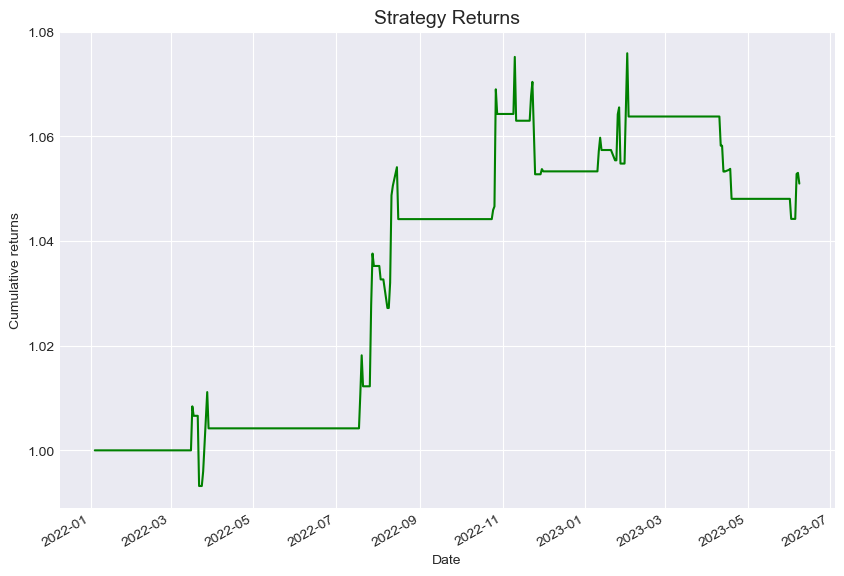

The maximum drawdown is -2.94


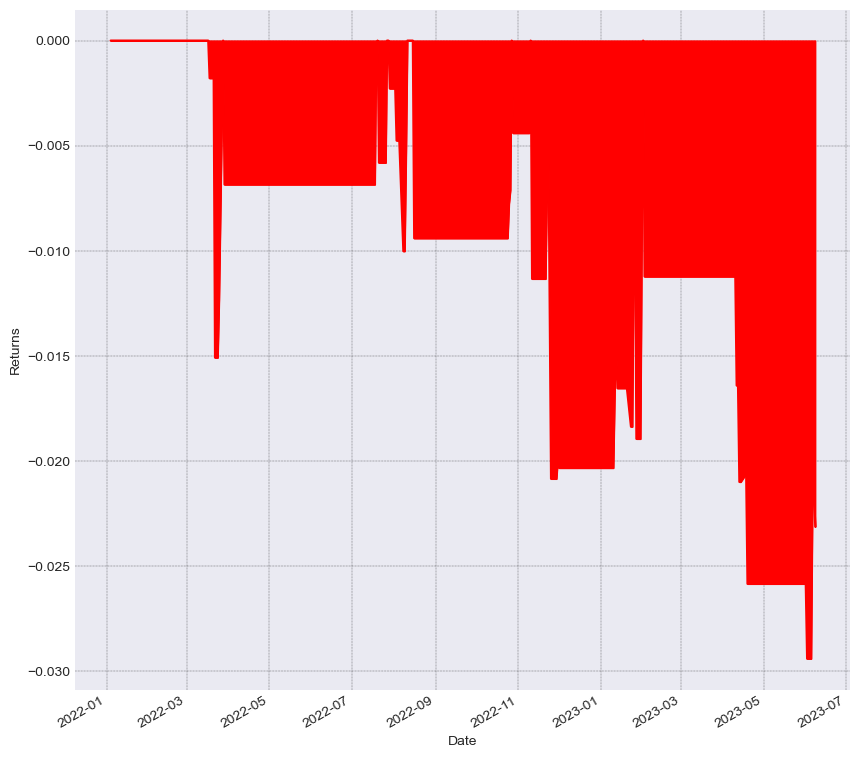

In [14]:

def get_strategy_returns_sma_breakout(portfolio):
    # Calculate the simple moving average 
    sma20 = portfolio.value > portfolio.value.rolling(window=20).mean()
    # Calculate the breakout indicator values
    breakout = portfolio.value>=portfolio.value.rolling(window=20).max()
   
    
    # Create a trading signal
    portfolio['signal'] = np.where(sma20 & breakout > 0.55 ,1,0)

    # Calculate the strategy returns
    portfolio['str_returns'] = portfolio['returns'].shift(-1) * portfolio['signal']
    return portfolio


def plot_signal(portfolio):
    portfolio['value'].plot(color='blue')    
    plt.fill_between(portfolio.index, portfolio.value, where=(portfolio.signal==1), facecolor='g', alpha=0.2)      
    plt.legend()
    plt.ylabel('Portfolio Value',color='r')
    # Plot the signal values    
    portfolio['signal'].plot(secondary_y=True,figsize=(15,10),color='grey', linestyle='dotted')
    plt.ylabel('Signal',color='r')
    plt.show()
    
portfolio = get_strategy_returns_sma_breakout(portfolio)
plot_signal(portfolio)    
plot_returns_dd(portfolio)
